In [131]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sidetable as stb

from scipy import stats
import researchpy as rp
from scipy.stats import levene
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

In [132]:
df = pd.read_pickle('data/bikes_limpio.pkl')

In [133]:
# Comenzaremos eliminando las columnas de registrado y total, ya que en este modelo nuestra VR será casual.
df = df.drop(["registrado", "total"], axis = 1)

Comprobaremos si se cumplen las asunciones de nuestros datos:

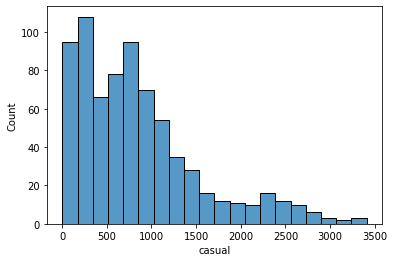

In [134]:
# Vamos a observar visualmente si nuestros datos son normales.
sns.histplot(x = df["casual"],  bins=20);

En principio parece que nuestros datos no son normales ya que no se asemejan a una campana de Gauss, pero lo comprobaremos de forma analítica.

In [135]:
# Comprobamos la normalidad con el test de shapiro ya que tenemos una muestra de datos pequeña:
stats.shapiro(df["casual"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

El test nos confirma que nuestros datos NO son normales ya que nuestro p-value es menor a 0.05. Intentaremos normalizarlos.

In [136]:
# BOX-COX()
df["casual_box"], lambda_ajustada = stats.boxcox(df["casual"])

In [137]:
stats.shapiro(df["casual_box"])

ShapiroResult(statistic=0.9915913939476013, pvalue=0.000365116517059505)

Después de intentar normalizar con varios métodos, el que mejor resultado nos ha dado es el BoxCox, no bostante tampoco consigue normalizar nuestros datos, por lo que la asunción de normalidad no se cumple y no podremos realizar el ANOVA ni el algoritmo de regresión lineal.

Pasamos a estandarizar nuestros datos.

In [138]:
#eliminamos la columna respuesta
df_estand = df.select_dtypes(include = np.number).drop(["casual", "casual_box"], axis = 1)

In [139]:
robust = RobustScaler()

In [140]:
robust.fit(df_estand)

RobustScaler()

In [141]:
X_robust = robust.transform(df_estand)

In [142]:
df_robust = pd.DataFrame(X_robust, columns = df_estand.columns)
df_robust.head(2)

,temperatura,humedad,viento
0,-0.484733,0.861178,-0.212121
1,-0.423664,0.332332,0.696970


In [143]:
df[df_robust.columns] = df_robust

In [144]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,laboral,clima,temperatura,humedad,viento,casual,casual_box
0,2018-01-01,invierno,2018,enero,sí,lunes,no,niebla,-0.484733,0.861178,-0.212121,331,16.397820
1,2018-02-01,invierno,2018,febrero,no,jueves,sí,niebla,-0.423664,0.332332,0.696970,131,11.472437
2,2018-03-01,invierno,2018,marzo,no,jueves,sí,cielo despejado,-0.942748,-0.912861,0.681818,120,11.076035
3,2018-04-01,primavera,2018,abril,no,domingo,no,cielo despejado,-0.935115,-0.177284,-0.212121,108,10.613970
4,2018-05-01,primavera,2018,mayo,no,martes,sí,cielo despejado,-0.851145,-0.912861,0.060606,82,9.475537


In [145]:
df_categoricas = df.select_dtypes(include = "O")
df_categoricas.head()

,estacion,año,mes,festivo,dia_semana,laboral,clima
0,invierno,2018,enero,sí,lunes,no,niebla
1,invierno,2018,febrero,no,jueves,sí,niebla
2,invierno,2018,marzo,no,jueves,sí,cielo despejado
3,primavera,2018,abril,no,domingo,no,cielo despejado
4,primavera,2018,mayo,no,martes,sí,cielo despejado


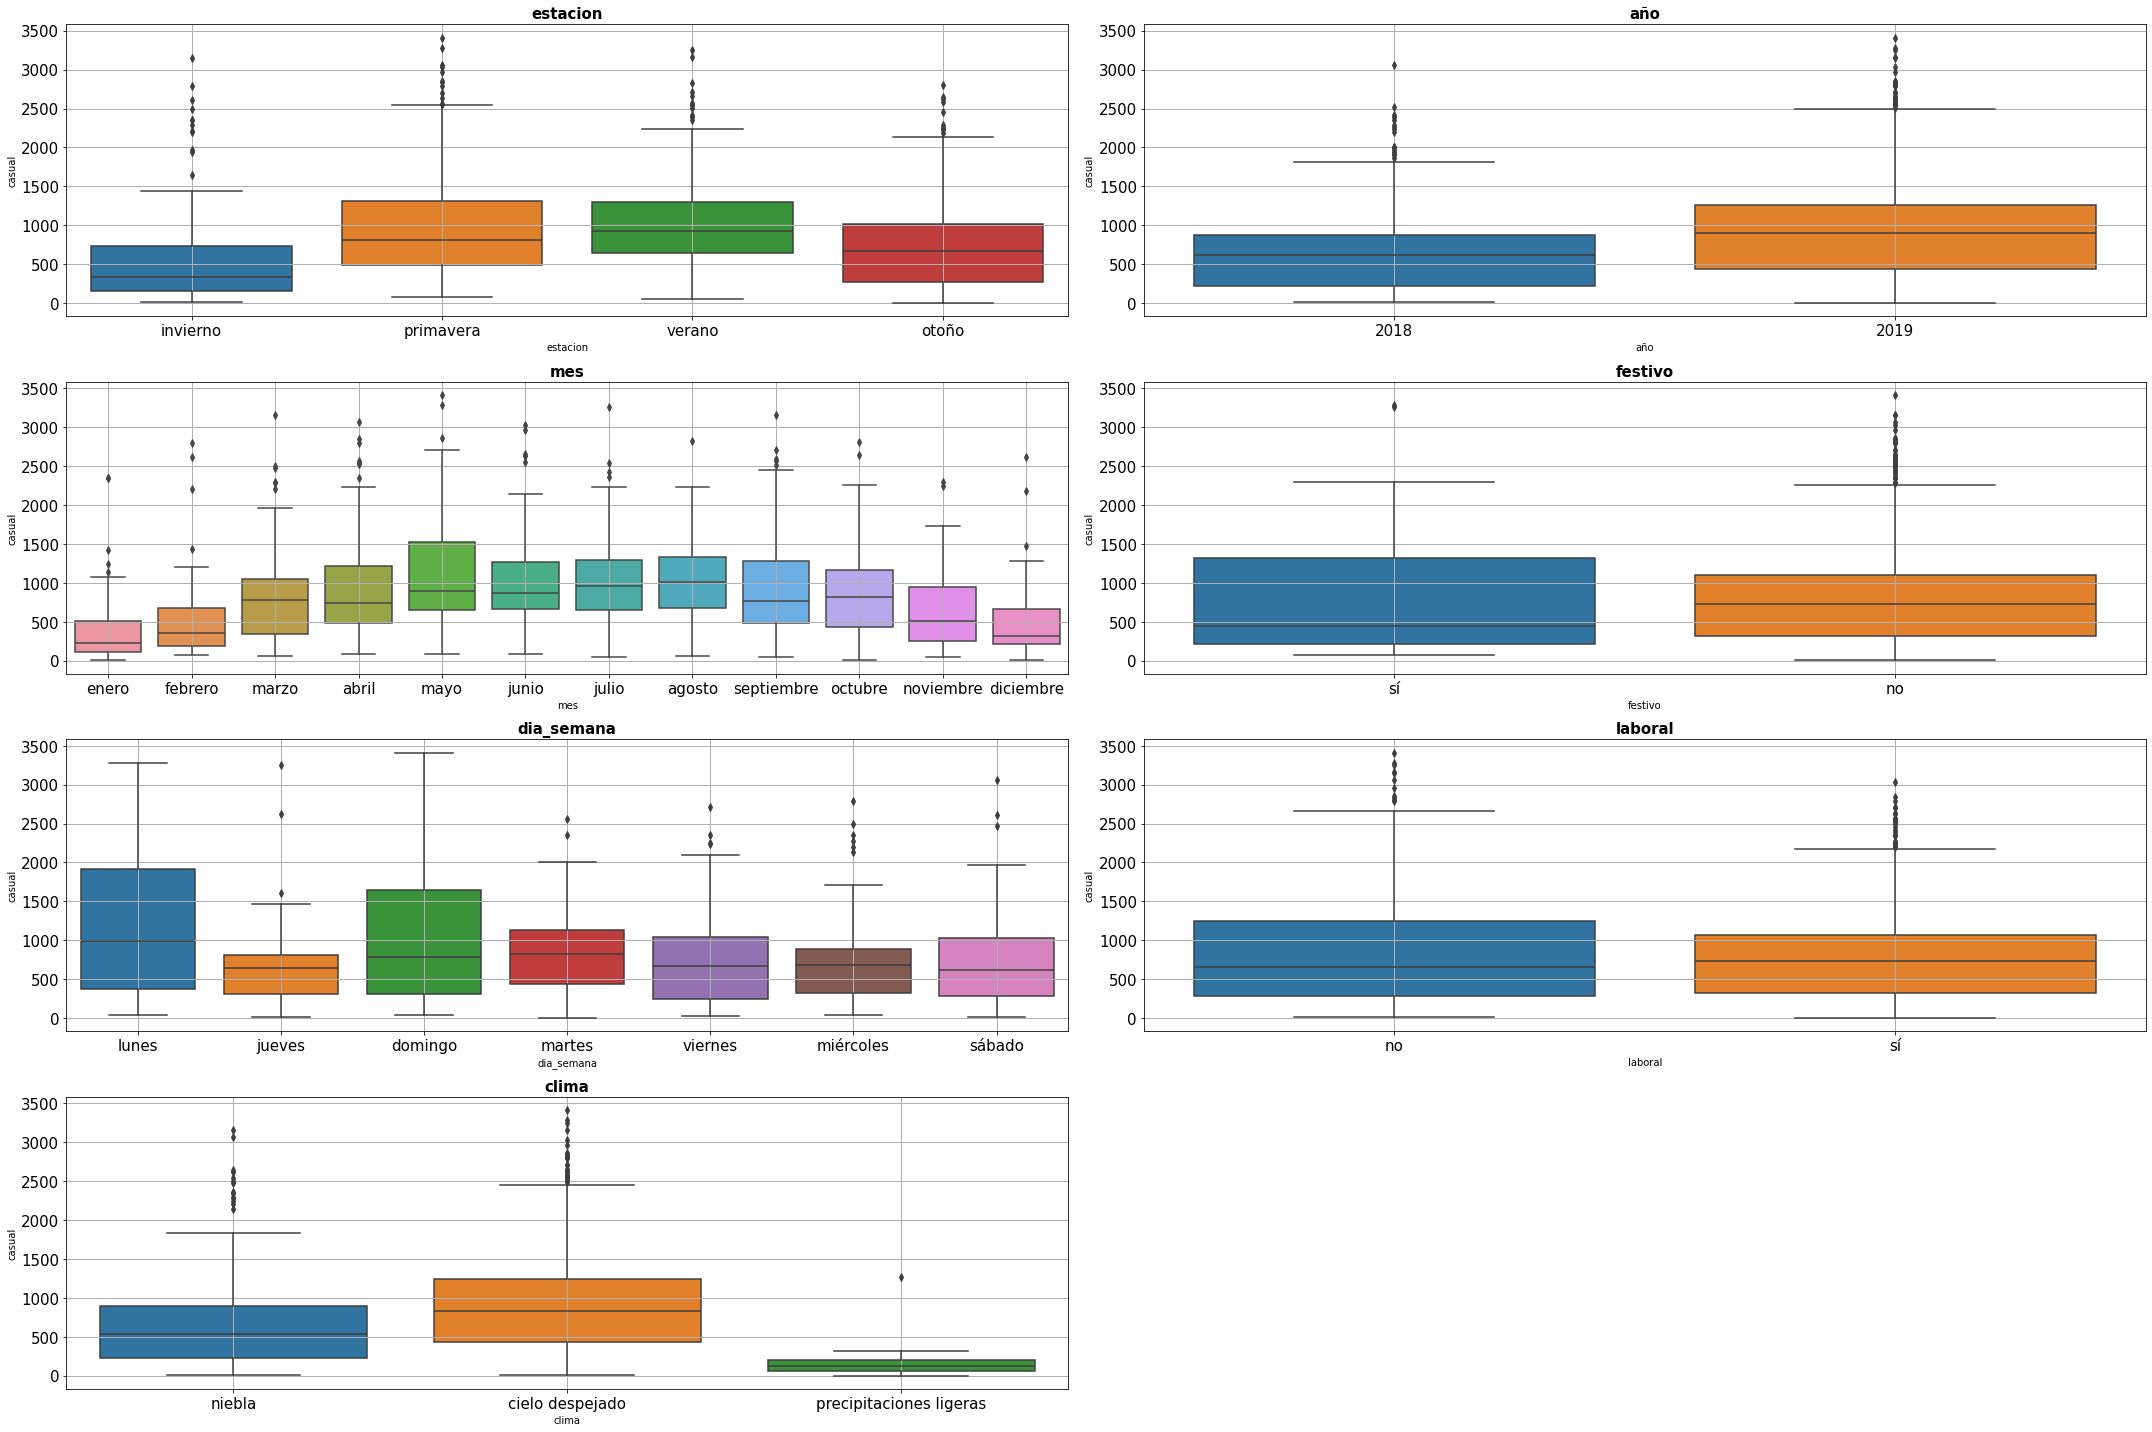

In [146]:
fig, axes = plt.subplots(4, 2, figsize = (30, 20))

axes = axes.flat

for i, columna in enumerate(df_categoricas): 
    sns.boxplot(
        data = df,
        x = columna,
        y = "casual",
        ax = axes[i])
    
    
    axes[i].set_title(columna, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 15)
    axes[i].grid(visible = True, linestyle = "-", linewidth = 1 )
fig.delaxes(axes[-1])
fig.tight_layout();

In [147]:
dict_estacion = {"invierno": 0, "otoño": 1, "primavera": 1.5, "verano": 2}
dict_mes = {"enero": 0, "febrero": 0, "diciembre": 0, "noviembre": 1, "marzo": 2, "abril": 2, "septiembre": 2, "octubre": 2, "mayo": 3, "junio": 3, "julio": 3, "agosto": 3}
dict_semana = {"jueves": 0, "viernes": 0, "sábado": 0, "miércoles": 0, "domingo": 0.5, "martes": 0.5, "lunes": 1}
dict_clima = {"precipitaciones ligeras": 0, "niebla": 1, "cielo despejado": 2}
dict_año = {"2018": 0, "2019": 1}
dict_festivo = {"sí": 0, "no": 1}

In [148]:
dict_map = {"estacion": dict_estacion, "mes": dict_mes, "dia_semana": dict_semana, "clima": dict_clima, "año": dict_año, "festivo": dict_festivo}
for columna, orden in dict_map.items():
    df[columna] = df[columna].map(orden)

In [149]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,laboral,clima,temperatura,humedad,viento,casual,casual_box
0,2018-01-01,0.0,0,0,0,1.0,no,1,-0.484733,0.861178,-0.212121,331,16.397820
1,2018-02-01,0.0,0,0,1,0.0,sí,1,-0.423664,0.332332,0.696970,131,11.472437
2,2018-03-01,0.0,0,2,1,0.0,sí,2,-0.942748,-0.912861,0.681818,120,11.076035
3,2018-04-01,1.5,0,2,1,0.5,no,2,-0.935115,-0.177284,-0.212121,108,10.613970
4,2018-05-01,1.5,0,3,1,0.5,sí,2,-0.851145,-0.912861,0.060606,82,9.475537


In [150]:
# dummies = pd.get_dummies(df["laboral"], prefix = "laboral", prefix_sep="_", dtype = int)

In [156]:
oh = OneHotEncoder()
transformados = oh.fit_transform(df[["laboral"]])
oh_df = pd.DataFrame(transformados.toarray())
oh_df.columns = oh.feature_names_in_()
df = pd.concat([df,oh_df],axis=1)

AttributeError: 'OneHotEncoder' object has no attribute 'feature_names_in_'

In [ ]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,humedad,viento,casual,casual_box,x0_no,x0_sí
0,2018-01-01,0.0,0,0,0,1.0,1,-0.484733,0.861178,-0.212121,331,16.397820,1.0,0.0
1,2018-02-01,0.0,0,0,1,0.0,1,-0.423664,0.332332,0.696970,131,11.472437,0.0,1.0
2,2018-03-01,0.0,0,2,1,0.0,2,-0.942748,-0.912861,0.681818,120,11.076035,0.0,1.0
3,2018-04-01,1.5,0,2,1,0.5,2,-0.935115,-0.177284,-0.212121,108,10.613970,1.0,0.0
4,2018-05-01,1.5,0,3,1,0.5,2,-0.851145,-0.912861,0.060606,82,9.475537,0.0,1.0


In [ ]:
#df = df.drop("laboral", axis = 1)
#df.head()

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,humedad,viento,casual,casual_box,x0_no,x0_sí
0,2018-01-01,0.0,0,0,0,1.0,1,-0.484733,0.861178,-0.212121,331,16.397820,1.0,0.0
1,2018-02-01,0.0,0,0,1,0.0,1,-0.423664,0.332332,0.696970,131,11.472437,0.0,1.0
2,2018-03-01,0.0,0,2,1,0.0,2,-0.942748,-0.912861,0.681818,120,11.076035,0.0,1.0
3,2018-04-01,1.5,0,2,1,0.5,2,-0.935115,-0.177284,-0.212121,108,10.613970,1.0,0.0
4,2018-05-01,1.5,0,3,1,0.5,2,-0.851145,-0.912861,0.060606,82,9.475537,0.0,1.0


In [ ]:
df.to_pickle("data/procesados_casual.pkl")
df.to_csv("data/procesados_casual.csv")